## Measuring intensities of lateral vs basal membranes in notochord cells

For this dataset we measured the intensity profile of a line drawn over either the lateral or basal membrane of Ciona notochord cells expressing E-cadherin. In this notebook we will gather all the data into a managable format and do some visualizations and analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy import signal
from joblib import Parallel, delayed
import scikit_posthocs as sp
import seaborn as sns

In [2]:
#The data lives in individual csv files that we can import as dataframes.
paths = glob.glob("./data/**/*.csv", recursive=True)

In [3]:
#Lets examine some paths, and split by dir:
print(paths[5].split("/"))
print(paths[-10].split("/"))

['.', 'data', 'gd3', 'lateral', 'Series009 lateral Values.csv']
['.', 'data', '2apb', 'basal', 'series 046 2nd basal values.csv']


The data structure is such that if we take the second and third entries in these lists we have the drug and membrane info sorted.

In [4]:
#first get a dataframe with all paths tagged with the relevant drug and membrane in the metadata
paths_array = np.vstack([path.split("/") for path in paths])
paths_array = paths_array[:,2:4]
all_data = pd.DataFrame(paths_array, columns = ["drug", "membrane"])
all_data["paths"] = paths

In [5]:
#then add all dataframes into a new column
all_data["dataframes"] = [pd.read_csv(path) for path in all_data["paths"]]

In [6]:
all_data.head()

,drug,membrane,paths,dataframes
0,gd3,lateral,./data/gd3/lateral/Series033 lateral Values.csv,X Y 0 0.00000 115.000 1 ...
1,gd3,lateral,./data/gd3/lateral/Series009 2nd lateral Value...,X Y 0 0.0000 77.000 1 ...
2,gd3,lateral,./data/gd3/lateral/Series031 lateral Values.csv,X Y 0 0.0000 154.000 1 ...
3,gd3,lateral,./data/gd3/lateral/Series011 lateral Values.csv,X Y 0 0.0000 77.000 1 ...
4,gd3,lateral,./data/gd3/lateral/Series020 3rd lateral Value...,X Y 0 0.0000 115.000 1 ...


A dataframe for a single measurement looks like this:

In [7]:
print(np.random.choice(all_data.dataframes))

           X        Y
0     0.0000  115.000
1     0.0651  122.752
2     0.1302  115.564
3     0.1953  173.746
4     0.2603  119.983
..       ...      ...
164  10.6738   93.333
165  10.7388  112.964
166  10.8039   77.000
167  10.8690   77.000
168  10.9341   77.000

[169 rows x 2 columns]


It seems that in X we have the location along the line in $\mu m$. Y is the intensity values. We want to align all the peaks to compare intensity. This means that for every X_column we need to find the halfway point `len(df)//2` and subtract the X_value at that index from the entire column X. We will store these values in a new column `X_centered` for now. At the same time we will subtract the lowest value from the data to set the baselines roughly equal, since we are not interested in absolute values as much as peak height. 

Note: This method works because we made sure to center the line over the membrane when collecting the data. If this is not a given we'd have to do peak-finding and centering on that.

In [8]:
def center_X(i):
    dataframe = all_data["dataframes"][i]
    dataframe["X_centered"] = dataframe["X"] - dataframe["X"].iloc[len(dataframe)//2]
    dataframe.set_index("X_centered", inplace = True)
    dataframe.drop("X", axis =1, inplace = True)
    dataframe["Y"] -= dataframe["Y"].dropna().min()
    dataframe["Y"] -= dataframe["Y"].dropna().median()
    dataframe.columns = [f'{all_data.drug[i]}_{all_data.membrane[i]}_{str(i).zfill(3)}']
    return dataframe

In [9]:
all_data["centered_dfs"] = Parallel(n_jobs = -1, verbose = 3)(delayed(center_X)(i) for i in all_data.index)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:   54.1s finished


Now a dataframe looks like this: Peak centered around zero. 

First five rows of dataframe: 

            gd3_lateral_000
X_centered                 
-4.75113            -14.264
-4.68605            -14.264
-4.62096            -14.264
-4.55588            -27.114
-4.49079            -31.276


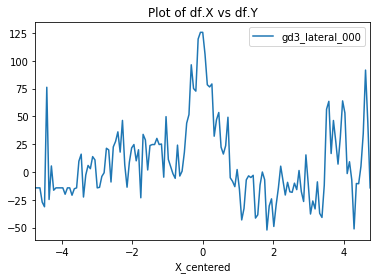

In [10]:
df = all_data["centered_dfs"][0]
print(f"First five rows of dataframe: \n\n{df.head()}")
fig, ax = plt.subplots()
df.plot(ax = ax);
title = ax.set_title("Plot of df.X vs df.Y")

In [11]:
#Save this data as hdf5 for later.
all_data.to_hdf("all_data_centered.hdf5", key = "data")

/home/daniel/python-virtualenvs/euro/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['drug', 'membrane', 'paths', 'dataframes', 'centered_dfs']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Visualizing ratios

In this dataset we are interested in the ratio of peak-height of lateral versus basal membranes, and how the different treatments influence these ratios. For this purpose, it will be useful to have a function that can retrieve the dataframes from the frame we made previously, and put them in a single flat structure instead of the nested structure the data lives in currently.


In [12]:
#function that creates separate dataframes out of the mother-dataframe where data is separated by drug and membrane
def make_concatenated_dataframes(data):
    concatenated_dataframes = {}
    for drug in all_data.drug.unique():
        concatenated_dataframes[drug] = {}
        for membrane in all_data.membrane.unique():
            concatenated_dataframes[drug][membrane] = pd.concat(list(data.centered_dfs[(data.drug == drug) 
                                                                                           & (data.membrane == membrane)]), axis = 1)
            concatenated_dataframes[drug][membrane] = concatenated_dataframes[drug][membrane].interpolate().dropna()
    return concatenated_dataframes

Now we van visualize all data per drug and per membrane:

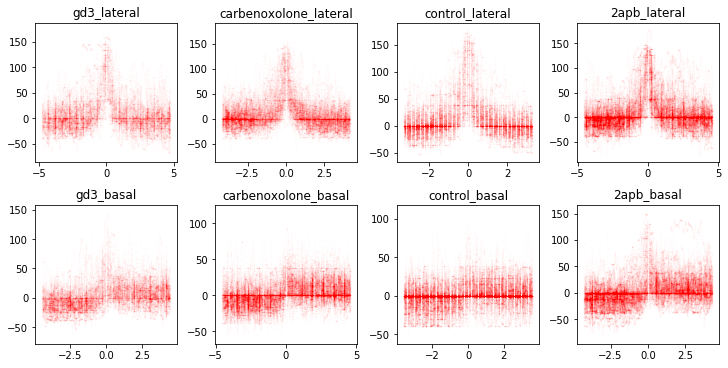

In [13]:
 def plot_scatters(data):
    concatenated_dataframes = make_concatenated_dataframes(data)
    fig, axes = plt.subplots(2, 4, figsize = (10, 5), constrained_layout = True)
    for i, membrane in enumerate(data.membrane.unique()):
        for j, drug in enumerate(data.drug.unique()):
            df = concatenated_dataframes[drug][membrane]
            #make symmetry
            df = df[:np.abs(np.min(df.index))]
            for col in df.columns:
                axes[i,j].scatter(df.index, df[col], s = 1, alpha = 0.01, c = "r")
                axes[i,j].set_title(f"{drug}_{membrane}")
    return fig
fig = plot_scatters(all_data)
# fig.savefig("all_scatters.png")
# fig.savefig("all_scater.svg")

It would be nicer to have this as the mean and standard deviation instead of scatters:

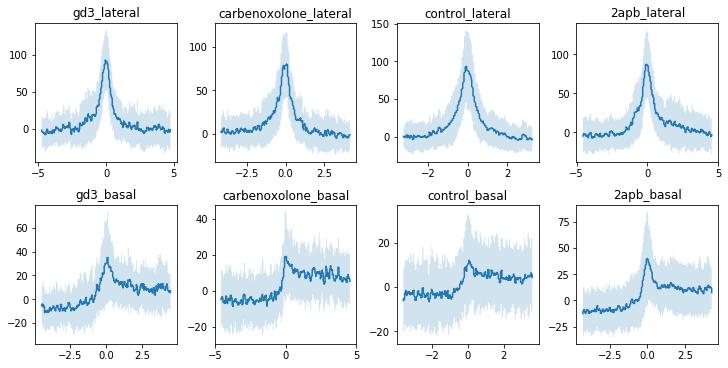

In [14]:
def plot_fill_individual(data):
    concatenated_dataframes = make_concatenated_dataframes(data)
    fig, axes = plt.subplots(2, 4, figsize = (10, 5), constrained_layout = True)
    for i, membrane in enumerate(data.membrane.unique()):
        for j, drug in enumerate(data.drug.unique()):
            df = concatenated_dataframes[drug][membrane]
            #make symmetry
            df = df[:np.abs(np.min(df.index))]
            mean = df.mean(axis = 1)
            std = df.std(axis = 1)
            axes[i,j].plot(mean)
            axes[i,j].fill_between(x = df.index, y1 = mean + std, y2 = mean - std, alpha = 0.2)
            axes[i,j].set_title(f"{drug}_{membrane}")   
    return fig
fig = plot_fill_individual(all_data)
# fig.savefig("mean_stdregion_two_axes.png")
# fig.savefig("mean_stdregion_two_axes.svg")

If we put both membranes per drug into the same plot it will be even easier to interpret the plots:

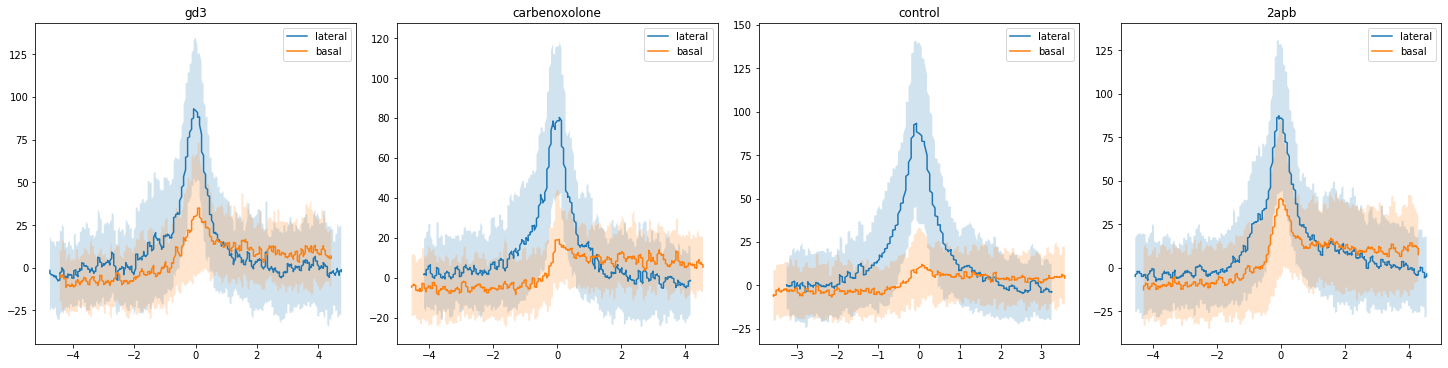

In [15]:
def plot_combined_data(data):
    concatenated_dataframes = make_concatenated_dataframes(data)
    fig, axes = plt.subplots(1, 4, figsize = (20, 5), constrained_layout = True)
    for i, membrane in enumerate(data.membrane.unique()):
        for j, drug in enumerate(data.drug.unique()):
            df = concatenated_dataframes[drug][membrane]
            #make symmetry
            df = df[:np.abs(np.min(df.index))]
            mean = df.mean(axis = 1)
            std = df.std(axis = 1)
            axes[j].plot(mean, label = membrane)
            axes[j].fill_between(x = df.index, y1 = mean + std, y2 = mean - std, alpha = 0.2)
            axes[j].set_title(f"{drug}")  
            axes[j].legend()
    return fig
fig = plot_combined_data(all_data)
# fig.savefig("mean_stdregion_one_axes.png")
# fig.savefig("mean_stdregion_one_axes.svg")

This shows a clear effect of the treatments on the intensity rations in the different membrane locations. It would be interesting to compare the rations of all individual measurements with each other. For this we need to compare the lateral and basal data from corresponding files, which is a bit of hassle with the given raw data structure. We can reduce the information in the paths to somewhat unique IDs that we can then use to match the lateral and basal measurement obtained from the same cell. 

In [16]:
ids = all_data.paths.str.split("/").apply(pd.Series)[4].str.lower().str.replace(" ", "_")
ids_correct = ["series_"+i[6:] if not i.startswith("series_") else i for i in ids]
ids_correct = [i.rstrip("_lateral_values.csv") if "lateral" in i else i.rstrip("_basal_values.csv") for i in ids]
all_data["id"] = ids_correct

Then we can find the values and create a new dataframe where per cell per membrane the mean value around the peak is taken.

In [17]:
means = []
for drug in all_data.drug.unique():
    data = all_data[all_data.drug == drug]
    for i in data.id.unique():
        try:
            dfs = data.centered_dfs[(data.id == i) & (data.drug == drug)]
            minval = np.min([df[df.columns[-1]].min() for df in dfs])
            for df in dfs:
                col = [col for col in df.columns][0]
                df = df[:np.abs(np.min(df.index))]
                df[col+"_corr"] = df[col] + minval
                meanval = df[col][-.1:.1].mean() 
                
                if "lateral" in col.lower():
                    means.append({"membrane": "lateral","mean": meanval, "drug":drug, "id":i,"trace":df[col]})
                else:
                    means.append({"membrane":"basal","mean": meanval, "drug":drug, "id":i, "trace":df[col]})
            
        except Exception as e:
            traceback.format_exception()
            print(f"{drug}_{i}")
    
mean_df = pd.DataFrame(means)

/home/daniel/python-virtualenvs/euro/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


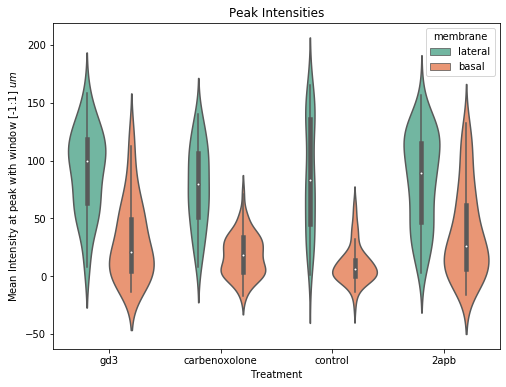

In [18]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (8,6))
violinplot = sns.violinplot(data=mean_df, x="drug", y = "mean", hue="membrane", ax = ax, palette="Set2");
ax.set_ylabel("Mean Intensity at peak with window [-1:1] $um$")
ax.set_xlabel("Treatment")
ax.set_title("Peak Intensities");

To calculate the ratios of intensity around the peaks of the apical and basal membranes of individual cells we have to reorganize this data a bit:

In [19]:
all_ratios = []
for drug in mean_df.drug.unique():
    data_per_drug = mean_df[mean_df.drug == drug]
    for i in mean_df.id.unique():
        data_per_id = data_per_drug[data_per_drug.id == i]
        min_val = 0
        for trace in data_per_id.trace:
            if trace.min() < min_val:
                min_val = trace.min()
        for trace in data_per_id.trace:
            trace-=min_val
        means = {"drug":drug, "id": i}
        for membrane in data_per_id.membrane.unique():
            trace = data_per_id.trace[data_per_id.membrane == membrane].iloc[0]
            means[membrane] = np.nanmean(trace[-1:1])
        
        all_ratios.append(means)
        
all_ratios_df = pd.DataFrame(all_ratios)
all_ratios_df["ratio"] = all_ratios_df["lateral"] / all_ratios_df["basal"]
all_ratios_df = all_ratios_df.dropna()

In [20]:
mannwhitney_results = sp.posthoc_mannwhitney(all_ratios_df, group_col="drug", val_col="ratio", p_adjust="holm")
# test_results.to_csv("ratio_pvalues_FILTERED_mannwhitney.txt", sep = "\t")

ttest_results = sp.posthoc_ttest(all_ratios_df, group_col="drug", val_col="ratio", p_adjust="holm")
# test_results.to_csv("ratio_pvalues_FILTERED_ttest.txt", sep = "\t")

In [21]:
ttest_results

,gd3,carbenoxolone,control,2apb
gd3,-1.000000,0.281976,0.000867,0.658397
carbenoxolone,0.281976,-1.000000,0.013616,0.427285
control,0.000867,0.013616,-1.000000,0.000816
2apb,0.658397,0.427285,0.000816,-1.000000


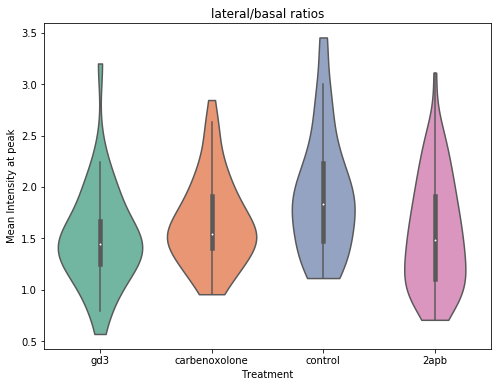

In [22]:
fig, ax = plt.subplots(figsize = (8,6))
violinplot = sns.violinplot(data=all_ratios_df, x="drug", y = "ratio", ax = ax, palette="Set2", cut = False);
ax.set_ylabel("Mean Intensity at peak")
ax.set_xlabel("Treatment")
ax.set_title("lateral/basal ratios");